# Ensemble Learning through Batch Boosting


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *
from basic_estimator_model import *

## Parameter Configuration

In [2]:
np.random.seed(2020)

In [3]:
N_train =1000
N_test = 50000
Max_Iter = 50
Ratio = 0.30
d = 1
T = 2

In [4]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [5]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


In [6]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [7]:
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = s_test.generate_true_V(T)
V_0 = s_test.generate_true_V(0)

V_T_train = s_train.generate_true_V(T)
V_0_train = s_train.generate_true_V(0)

V_0_train = V_0_train.mean()
V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.07966926864511534

In [8]:
from aggregating.utils import flatten_X, normalized_error_VT
#dim(N_test,d*T)
Flattened_X_test = flatten_X(X_test)
# dim(N_train, d*T)
Flattened_X_train = flatten_X(X_train)

In [9]:
#Model with Flatten_X_1
m_1 = EstimatorModelBase(kernel)
m_1.fit(Flattened_X_train,y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=39.2) + WhiteKernel(noise_level=0.5))

In [10]:
fX_1 = m_1._predict_fX(Flattened_X_test)

In [11]:
fX_2 = m_1._predict_fX(Flattened_X_train)

In [12]:
test_reference_error = normalized_error_VT(fX_1 ,V_T, V_0)

In [13]:
train_reference_error = normalized_error_VT(fX_2 ,V_T_train, V_0_train)

In [14]:
train_reference_error

0.022946493453321455

In [15]:
test_reference_error

0.19087255877978457

## Batch Boosting

In [17]:
def Bacth_Boosting(X_train, y_train, X_test, y_test, Max_Iter, min_error, early_stop, kernel):
    error_going_up = 0
    train_prediction = np.zeros(N_train)
    test_prediction = np.zeros(N_test)
    previous_y_hat = np.zeros(N_train)
    previous_y_test_hat = np.zeros(N_test)
    models = []
    train_errors = []
    test_errors = []
    
    original_y_train = y_train

    
    for i in range(Max_Iter):
        model = GaussianProcessRegressor(kernel)
    
        y_train = y_train - previous_y_hat
    
        model.fit(X_train, y_train)
        models.append(model)
        
        #Evaluating on TrainSet
        previous_y_hat = model.predict(X_train) 
        
        train_prediction += previous_y_hat
        
        train_errors.append(normalized_error_VT(train_prediction,original_y_train,V_0_train).item())
        
        ##Evaluating on TestSet
        
        previous_y_test_hat = model.predict(X_test)
      
        test_prediction += previous_y_test_hat
        
        test_errors.append(normalized_error_VT(test_prediction,y_test,V_0).item())
    
        if (test_errors[-1] < min_error[0]):
            min_error = (test_errors[-1], i)
            error_going_up = 0
            print('For iteration number {}, the test error decreased '.format(i))
        else:
            error_going_up += 1
            print('For iteration number {}, the test error increased '.format(i))
        
            if  (i==(Max_Iter-1)):
                models = models[:min_error[1]+1]
                
                return models, train_errors, test_errors, min_error
        
            elif (error_going_up == early_stop ):
                models = models[: -(early_stop)]
                
                return models, train_errors, test_errors, min_error
                break #early stopping
            
    return models, train_errors, test_errors, min_error

In [18]:


models, train_error, test_error, min_error = Bacth_Boosting(np.copy(Flattened_X_train), np.copy(y_train), np.copy(Flattened_X_test), np.copy(y_test), Max_Iter, (float("inf"), float("inf")), 5, kernel)



For iteration number 0, the test error decreased 
For iteration number 1, the test error decreased 
For iteration number 2, the test error decreased 
For iteration number 3, the test error decreased 
For iteration number 4, the test error increased 
For iteration number 5, the test error increased 
For iteration number 6, the test error increased 
For iteration number 7, the test error increased 
For iteration number 8, the test error increased 


In [19]:
y_pred = sum(m.predict(Flattened_X_test) for m in models)

In [20]:
normalized_error_VT(y_pred , y_test, V_0).item()

0.19087251936926605

In [21]:
train_error_array = np.array(train_error)
test_error_array = np.array(test_error)

In [22]:
normalized_train_error = (train_error_array - np.mean(train_error_array, axis=0))/np.std(train_error_array)
normalized_test_error = (test_error_array - np.mean(test_error_array, axis=0))/np.std(test_error_array)

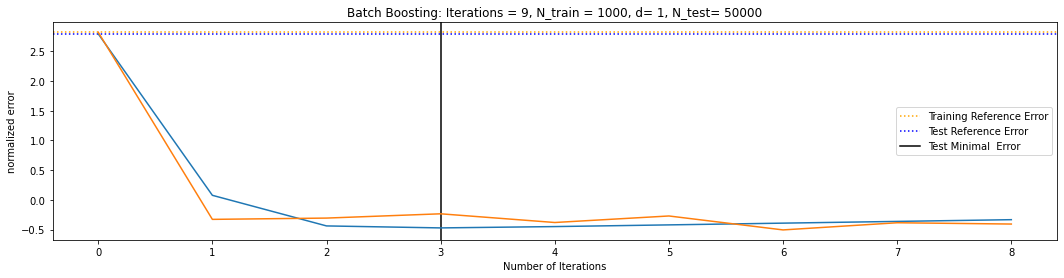

In [23]:
plt.figure(figsize = (18, 4))
plt.axhline(normalized_train_error[0], ls=':', color = 'orange', label = 'Training Reference Error')
plt.axhline(normalized_test_error[0], ls=':', color = 'blue', label = 'Test Reference Error')
plt.axvline(min_error[1], ls='-', color = 'k', label = 'Test Minimal  Error')
plt.plot(np.arange(len(test_error)) , normalized_test_error)
plt.plot(np.arange(len(train_error)) , normalized_train_error)
plt.title(f"Batch Boosting: Iterations = {len(train_error)}, N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("Number of Iterations")

plt.ylabel("normalized error")
plt.legend(loc='center right')
plt.show()

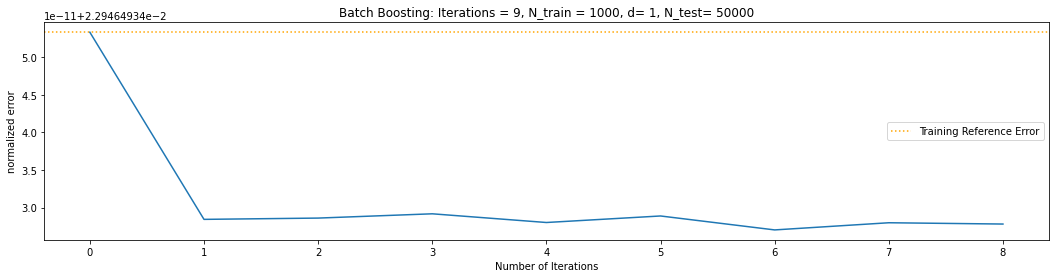

In [24]:
plt.figure(figsize = (18, 4))
plt.axhline(train_error[0], ls=':', color = 'orange', label = 'Training Reference Error')
plt.plot(np.arange(len(train_error)) ,train_error)
plt.title(f"Batch Boosting: Iterations = {len(train_error)}, N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("Number of Iterations")

plt.ylabel("normalized error")
plt.legend(loc='center right')
plt.show()

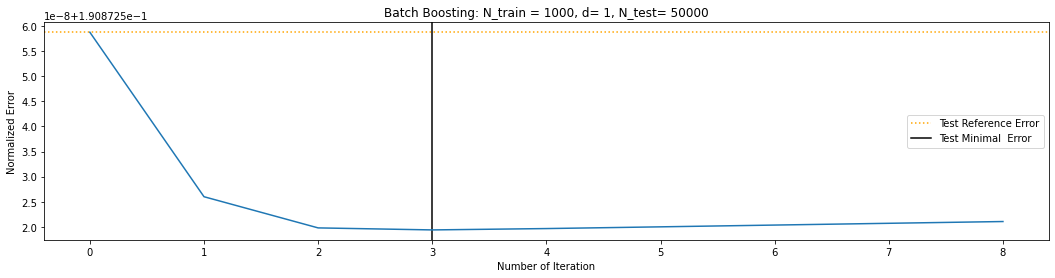

In [25]:
plt.figure(figsize = (18, 4))
plt.axhline(test_reference_error, ls=':', color = 'orange', label = 'Test Reference Error')
plt.axvline(min_error[1], ls='-', color = 'k', label = 'Test Minimal  Error')
plt.plot(np.arange(len(test_error)) , test_error)
plt.title(f"Batch Boosting: N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("Number of Iteration")

plt.ylabel("Normalized Error")
plt.legend(loc='center right')
plt.show()

In [ ]:
errors = []
Max_Iter_Range = 10
Ratios = np.linspace(0.1,1, num=10)
for r in :
    models_1, errors_1 = Stochastic_Boosting(Flattened_X_train, np.copy(y_train), Max_Iter, float('inf'),\
                                     20, round(Flattened_X_train.shape[0]*r))
    y_stoch_pred = sum(m.predict(Flattened_X_test) for m in models_1)
    errors.append(normalized_error_VT(y_stoch_pred , V_T, V_0))
    
    

## Stochastic Boosting

In [ ]:
def Stochastic_Boosting(X_train, y_train, Max_Iter, min_error, early_stop, sample_size):
    error_going_up = 0
    final_prediction = np.zeros(X_train.shape[0])
    previous_y_hat = np.zeros(X_train.shape[0])
    previous_predictions = np.zeros((Max_Iter, X_train.shape[0]))
    models = []
    errors = []
    original_y_train = y_train
    
    for i in range(Max_Iter):
       
        indices = np.random.choice(X_train.shape[0],size=sample_size,replace=False)
        model = GaussianProcessRegressor(kernel)
        
        y_train[indices] = y_train[indices] - previous_y_hat[indices]
    
        model.fit(X_train[indices], y_train[indices])
        models.append(model)
        
        previous_predictions[i,:] = model.predict(X_train) 
        previous_y_hat = previous_predictions[i,:]
    
    
        final_prediction += previous_y_hat
     
        errors.append(normalized_error_VT(final_prediction,original_y_train, V_0_train).item())
    
        if (errors[-1] < min_error):
            min_error = errors[-1]
            error_going_up = 0
            nb_of_models = i
            print('For iteration number {}, the error decreased '.format(i))
        else:
            error_going_up += 1
            print('For iteration number {}, the error increased '.format(i))
        
            if  (i==(Max_Iter-1)):
                models = models[:nb_of_models+1]
                return models, errors
        
            elif (error_going_up == early_stop ):
                models = models[: -early_stop]
                return models, errors
                break #early stopping
            
    return models, errors

In [ ]:
models_1, errors_1 = Stochastic_Boosting(Flattened_X_train, np.copy(y_train), Max_Iter, float('inf'),\
                                     20, round(Flattened_X_train.shape[0]*Ratio))

In [ ]:
plt.figure(figsize = (15, 7))

plt.plot(np.arange(len(errors_1)) , errors_1)
plt.show

In [ ]:
y_stoch_pred = sum(m.predict(Flattened_X_test) for m in models_1)

In [ ]:
normalized_error_VT(y_stoch_pred , V_T, V_0)

In [ ]:
errors = []
Max_Iter_Range = 10
Ratios = np.linspace(0.1,1, num=10)
for r in Ratios:
    models_1, errors_1 = Stochastic_Boosting(Flattened_X_train, np.copy(y_train), Max_Iter, float('inf'),\
                                     20, round(Flattened_X_train.shape[0]*r))
    y_stoch_pred = sum(m.predict(Flattened_X_test) for m in models_1)
    errors.append(normalized_error_VT(y_stoch_pred , V_T, V_0))
    
    